In [1]:
import numpy as np
import cv2
print ("OpenCV Version : %s " % cv2.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (20.0, 10.0)

PATH = "/home/piotrek/Data/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_28_48.jpg"
XML_PATH = "/home/piotrek/Data/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_28_48.xml"

#PATH = "/home/piotrek/Data/PKLot/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_17_12_25.jpg"
#XML_PATH = "/home/piotrek/Data/PKLot/PKLot/UFPR04/Sunny/2012-12-07/2012-12-07_17_12_25.xml"

OpenCV Version : 3.1.0 


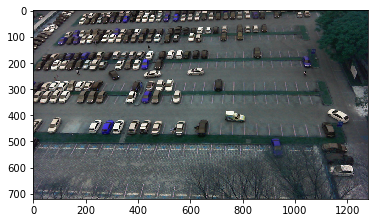

In [2]:
img = cv2.imread(PATH)
plt.imshow(img)

In [3]:
import xml.etree.ElementTree as ET
from lxml import etree

def get_points(xml_data):
    tree = etree.parse(xml_data)
    root = tree.getroot()
    parking = {"id":[], "occupied":[], "points":[], "rects":[]}
    for elem in root.iter("space"):
        space_points = []
        space_rects = []
        parking["id"].append(int(elem.attrib["id"]))
        try:
            parking["occupied"].append(int(elem.attrib["occupied"]))
        except:
            parking["occupied"].append(None)
            
        points_list = elem.xpath("contour/point")
        for p in points_list:
            space_points.append([int(p.attrib["x"]), int(p.attrib["y"])])
        parking["points"].append(space_points)
        
        rotatedRect = elem.xpath("rotatedRect")[0]
        for r in rotatedRect:
            if r.tag == "angle":
                space_rects.append(int(r.attrib["d"]))
            else:
                space_rects.append(tuple([int(e) for e in r.attrib.values()]))
        parking["rects"].append(tuple(space_rects))

    # check lengths
    assert len(parking["id"]) == len(parking["occupied"]) == len(parking["points"]) == len(parking["rects"])
    return parking

parking = get_points(XML_PATH)

print([item[0] for item in parking.values()])
#print(parking["points"][0])

[1, 0, [[278, 230], [290, 186], [324, 185], [308, 230]], ((300, 207), (55, 32), -74)]


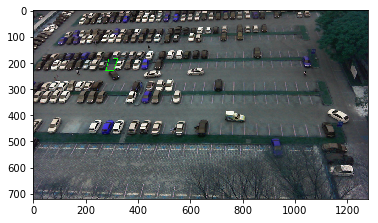

In [4]:
pts = np.array(parking["points"][0], np.int32)
cv2.polylines(img,[pts],True,(0,255,0),thickness=2)
plt.imshow(img)

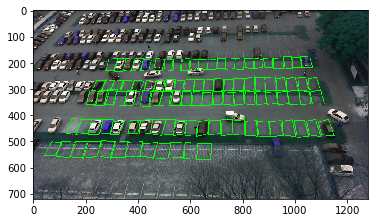

In [5]:
img = cv2.imread(PATH)
cv2.drawContours(img,np.array(parking["points"],np.int32),-1,(0,255,0),2)
plt.imshow(img)

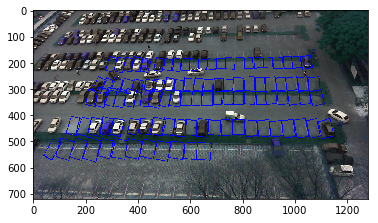

In [6]:
img = cv2.imread(PATH)

box = [cv2.boxPoints(e) for e in parking["rects"]]
box = np.int0(box)
cv2.drawContours(img,box,-1,(0,0,255),2)
plt.imshow(img)

(54, 32, 3)


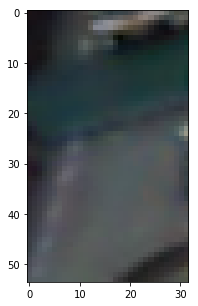

In [7]:
import cv2

def rotate_crop_image(mat, rect):
    (x, y) = rect[0]
    (w, h) = rect[1]
    angle = rect[2]
    w = int(w/2)
    h = int(h/2)
    if angle < -45:
        angle += 90
        w, h = h, w

    height, width = mat.shape[:2]
    image_center = (x, y)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (width, height))
    
    croppes_mat = rotated_mat[y-h: y + h, x-w: x + w]
    return np.array(croppes_mat)

plt.rcParams['figure.figsize'] = (10.0, 5.0)
img = cv2.imread(PATH)
img = rotate_crop_image(img, parking["rects"][0])
print(img.shape)
plt.imshow(img)

In [8]:
img = cv2.imread(PATH)
car_list = []
for rect in parking["rects"]:
    #print((rotate_image(img, rect)).shape)
    car_list.append(rotate_crop_image(img, rect))

print(len(car_list))

100


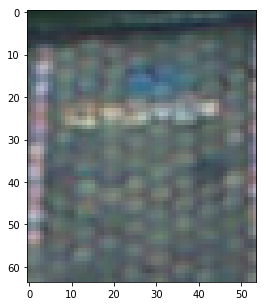

In [11]:
plt.imshow(car_list[-1])